In [1]:
!pip install ultralytics  # установка Ultralytics YOLOv8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [24]:
import ultralytics
print(f"Ultralytics version: {ultralytics.__version__}")

import os
import shutil
import random
import json
from pathlib import Path
from ultralytics import YOLO
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


Ultralytics version: 8.3.155
cuda


In [7]:
#Пути
data_dir = Path("/kaggle/input/chicken-detection/dataset/train")
json_path = data_dir / "_annotations.coco.json"

#Загрузка аннотаций
with open(json_path) as f:
    coco = json.load(f)

#Проверка
print(f" Изображений: {len(coco['images'])}")
print(f" Аннотаций: {len(coco['annotations'])}")
print(f" Категории: {coco['categories']}")


 Изображений: 375
 Аннотаций: 1043
 Категории: [{'id': 0, 'name': 'Chicken', 'supercategory': 'none'}, {'id': 1, 'name': 'Chicken', 'supercategory': 'Chicken'}]


In [8]:
base_dir = Path("/kaggle/working/chicken_data")
for split in ['train', 'val', 'test']:
    (base_dir / "images" / split).mkdir(parents=True, exist_ok=True)
    (base_dir / "labels" / split).mkdir(parents=True, exist_ok=True)

#Разделение
images = coco['images']
random.seed(42)
random.shuffle(images)
n_total = len(images)
train_imgs = images[:int(0.7 * n_total)]
val_imgs = images[int(0.7 * n_total):int(0.9 * n_total)]
test_imgs = images[int(0.9 * n_total):]

id_to_image = {img['id']: img for img in coco['images']}
annotations_by_image = {}
true_counts = {}

#Используем только category_id == 1 (или всё → 0)
for ann in coco['annotations']:
    img_id = ann['image_id']
    img_info = id_to_image[img_id]
    fname = img_info['file_name']
    true_counts[fname] = true_counts.get(fname, 0) + 1

    x, y, w, h = ann['bbox']
    iw, ih = img_info['width'], img_info['height']
    x_c, y_c = (x + w/2) / iw, (y + h/2) / ih
    w_n, h_n = w / iw, h / ih
    line = f"0 {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}"  # класс 0

    annotations_by_image.setdefault(img_id, []).append(line)

def process_split(img_list, split_name):
    for img in img_list:
        fname = img['file_name']
        src = data_dir / fname
        dst_img = base_dir / "images" / split_name / fname
        dst_lbl = base_dir / "labels" / split_name / (fname.rsplit('.', 1)[0] + ".txt")
        shutil.copy(src, dst_img)
        if img['id'] in annotations_by_image:
            with open(dst_lbl, 'w') as f:
                f.write("\n".join(annotations_by_image[img['id']]))
process_split(train_imgs, "train")
process_split(val_imgs, "val")
process_split(test_imgs, "test")


In [25]:
import yaml

data_yaml = {
    'path': str(base_dir),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: "chicken"}
}

yaml_path = base_dir / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(yaml_path)


/kaggle/working/chicken_data/data.yaml


In [22]:
model = YOLO("yolov8s.pt")

results = model.train(
    data=str(yaml_path),
    epochs=100,
    imgsz=640,
    batch=16,
    name="chicken_yolo",
    patience=30,
    verbose=True
)


Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/chicken_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chicken_yolo3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plo

train: Scanning /kaggle/working/chicken_data/labels/train.cache... 262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 262/262 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 373.1±191.3 MB/s, size: 120.0 KB)


val: Scanning /kaggle/working/chicken_data/labels/val.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs/detect/chicken_yolo3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/chicken_yolo3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.66G      1.173       2.19      1.339         43        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         75        232      0.767       0.72      0.792      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.66G     0.9927      1.106      1.222         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         75        232      0.801       0.78       0.85       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.66G      1.074       1.07       1.22         35        640: 100%|██████████| 17/17 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.619      0.534      0.585      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.66G      1.068     0.9756      1.252         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.533      0.405      0.387      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.66G       1.11     0.9414      1.247         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         75        232      0.121      0.267     0.0976     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.66G       1.09     0.9268      1.265         37        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.468      0.461      0.429      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.66G      1.117     0.9702      1.261         39        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         75        232      0.337      0.405      0.328      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.66G      1.114     0.9505      1.277         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.377      0.336      0.286      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.66G      1.094     0.9474      1.267         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         75        232      0.572      0.645      0.645       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.66G       1.05     0.8729      1.226         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         75        232       0.61      0.737      0.705      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.66G      1.004     0.8566      1.191         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         75        232      0.677      0.672      0.699      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.66G     0.9829     0.7813      1.181         38        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         75        232      0.728       0.69       0.74      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.66G      0.963     0.7615      1.166         36        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.768      0.714       0.81      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.67G     0.9763     0.7631      1.176         27        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         75        232      0.752      0.746       0.81      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.67G      1.001     0.7962      1.207         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         75        232      0.822      0.853      0.878      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.71G       0.94     0.7605      1.177         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         75        232      0.772      0.832       0.87      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.71G     0.9397     0.7483      1.167         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.742      0.914      0.893      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.74G     0.9278     0.7192      1.157         31        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.874      0.853      0.904      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.74G      0.954     0.7743      1.172         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         75        232      0.829      0.884      0.922      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.78G     0.9445     0.7129      1.174         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.795      0.901      0.916      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.78G      0.917     0.7236      1.149         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         75        232      0.769      0.833      0.847      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.81G     0.8751     0.7168      1.126         39        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         75        232      0.792      0.841      0.888      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.82G     0.8693     0.6895      1.129         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         75        232      0.836      0.866      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.85G     0.8908     0.7111      1.128         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.811      0.884      0.903      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.85G     0.8628     0.7003      1.122         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         75        232      0.822      0.871      0.901      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.85G     0.8699      0.675      1.121         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.869      0.897       0.94      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.85G     0.8643     0.6769      1.138         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.934      0.908      0.951      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.85G     0.8124      0.613      1.078         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         75        232      0.903      0.927      0.963      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.85G        0.8     0.6168      1.094         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         75        232      0.862      0.945       0.95      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.85G     0.8225     0.6426      1.098         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.886      0.892      0.917      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.85G     0.8065     0.6108      1.078         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.864      0.874      0.931        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.85G     0.8391     0.6559      1.109         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         75        232      0.901      0.892      0.921      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.85G     0.7936     0.6263      1.089         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         75        232      0.908      0.895      0.937      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.85G     0.7531     0.5906      1.062         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         75        232      0.877      0.875      0.911      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.85G     0.7776     0.5893      1.071         55        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         75        232       0.89      0.901      0.944      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.85G     0.7849     0.5939      1.086         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         75        232      0.916      0.905      0.949      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.85G     0.7523     0.5998      1.064         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         75        232      0.896      0.931      0.942      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.85G     0.7476      0.564      1.066         31        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         75        232      0.909      0.909      0.942      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.85G     0.7287     0.5826      1.064         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.905      0.906       0.95      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.85G     0.7653     0.6002      1.069         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.882      0.934      0.938      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.85G     0.7301      0.567      1.058         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         75        232      0.881      0.956       0.93       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.85G     0.7287     0.5462       1.06         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.893      0.935      0.951      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.85G      0.724     0.5262      1.044         30        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         75        232      0.915      0.927      0.961      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.85G     0.7636     0.5717      1.061         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         75        232      0.914      0.944      0.951      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.85G     0.7035     0.5304      1.034         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         75        232       0.94      0.931      0.957      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.85G     0.7176     0.5446       1.05         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         75        232      0.924      0.909      0.948      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.85G     0.7051     0.5658      1.034         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.885      0.931       0.95      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.85G     0.7108     0.5308       1.04         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         75        232      0.934      0.922      0.955      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.85G     0.7357     0.5538      1.057         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.896      0.931      0.933      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.85G     0.6671     0.5061      1.013         31        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.911      0.931      0.937       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.85G     0.7099     0.5509      1.035         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.931      0.931      0.962      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.85G     0.6797     0.5301       1.02         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         75        232      0.887      0.966      0.949      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.85G     0.6657      0.514      1.014         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         75        232       0.93      0.922      0.949      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.85G     0.6774     0.5122      1.028         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         75        232      0.916      0.937       0.95      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.85G      0.679     0.5079      1.029         36        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.946      0.909      0.951      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.85G     0.6672     0.5098      1.027         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232       0.92       0.94      0.963      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.85G     0.6719     0.5007       1.04         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.941      0.909      0.956      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.85G     0.6515     0.4952      1.016         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         75        232       0.91      0.927      0.955       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.85G     0.6498     0.4981      1.009         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         75        232      0.915      0.935      0.959      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.85G     0.6257     0.4685      1.003         27        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         75        232      0.926       0.94      0.962      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.85G     0.6734     0.5164       1.04         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.944      0.936      0.961      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.85G     0.6648     0.4892      1.024         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.949       0.94      0.951      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.85G     0.6351     0.4654      1.003         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         75        232      0.946      0.912      0.943      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.85G     0.6427     0.4883     0.9976         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         75        232      0.925      0.961      0.957      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.85G     0.6088     0.4631      0.978         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         75        232      0.918      0.953      0.959      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.85G     0.6316     0.4801      1.013         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         75        232      0.935      0.948      0.966      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.85G     0.5903     0.4469     0.9927         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.913      0.955      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.85G     0.6176       0.47     0.9911         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         75        232      0.943      0.924      0.966      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.85G     0.6267     0.4519      1.021         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         75        232      0.934       0.94      0.961      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.85G     0.6207     0.4719     0.9973         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.925      0.944      0.957      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.85G     0.6005     0.4423      0.998         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         75        232      0.932      0.945      0.959      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.85G      0.597     0.4392     0.9834         48        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.948      0.938       0.96      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.85G     0.5937     0.4549     0.9901         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         75        232      0.956      0.922      0.959      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.85G     0.5551      0.416     0.9647         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         75        232      0.939      0.936      0.962      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.85G     0.5813     0.4375     0.9943         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.927      0.957      0.962      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.85G     0.5541     0.4128     0.9741         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         75        232      0.929      0.957      0.958      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.85G     0.5672     0.4169     0.9848         30        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.924      0.939      0.951      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.85G     0.5651     0.4135     0.9672         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         75        232      0.927      0.927      0.949      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.5646      0.427     0.9768         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.928      0.935      0.952      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.85G     0.5365     0.4251     0.9679         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         75        232      0.937      0.931      0.964      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.85G     0.5504     0.4069     0.9736         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.932      0.957       0.97      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.85G     0.5535       0.41     0.9649         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         75        232       0.91      0.965      0.955      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.85G      0.542     0.3963     0.9598         27        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         75        232      0.944      0.944      0.961      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.85G     0.5769      0.413     0.9844         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         75        232       0.94      0.941      0.964      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.85G     0.5193     0.3781     0.9511         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232      0.943      0.933      0.958      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.85G     0.5374     0.3934     0.9595         31        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         75        232      0.912      0.957       0.96      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.85G      0.525     0.3911     0.9394         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         75        232      0.924      0.941       0.96      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.85G      0.503     0.3799     0.9497         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.911      0.968      0.958      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.85G     0.5035     0.3637     0.9479         41        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.952      0.942      0.959      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.85G     0.5173     0.3727      0.963         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.932      0.949      0.961      0.831


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.85G     0.4217     0.3162     0.9008         17        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         75        232      0.936      0.947      0.958      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.85G     0.4248     0.3116     0.9063         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         75        232      0.914      0.967      0.957      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.85G      0.429     0.3173      0.903         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         75        232       0.91      0.962      0.954      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.85G     0.4166     0.3029     0.8913         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.917      0.949      0.949       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.85G     0.3951     0.2827     0.8841         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232       0.91      0.964      0.953      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.85G     0.3952     0.2903     0.8858         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         75        232      0.925      0.958      0.957      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.85G     0.3855     0.2824     0.8825         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         75        232      0.925      0.959      0.961      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.85G      0.386     0.2803     0.8685         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         75        232      0.904      0.972      0.959      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.85G     0.3975     0.2895     0.8999         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         75        232      0.907      0.968      0.959      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.85G     0.3878     0.2844     0.8863         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         75        232      0.908      0.961      0.958      0.836



100 epochs completed in 0.167 hours.
Optimizer stripped from runs/detect/chicken_yolo3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/chicken_yolo3/weights/best.pt, 22.5MB

Validating runs/detect/chicken_yolo3/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         75        232      0.924      0.957      0.961      0.844
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/chicken_yolo3


MAE (средняя ошибка по количеству): 0.395
RMSE: 0.987
Accuracy@adaptive_tolerance: 94.74%


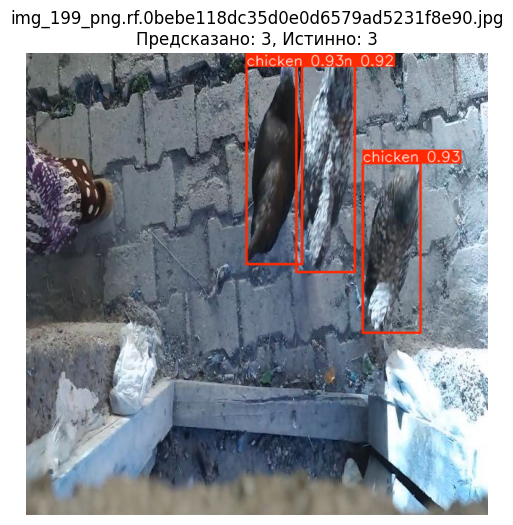

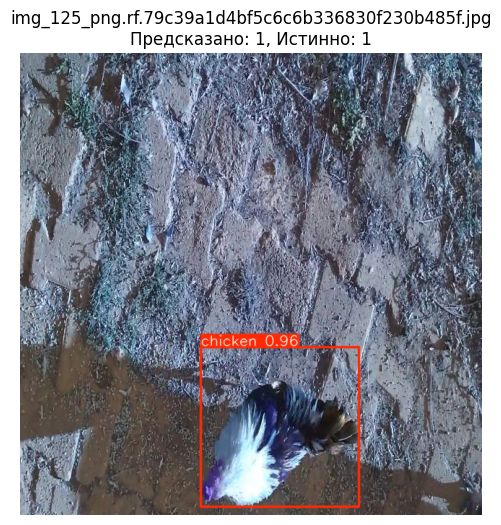

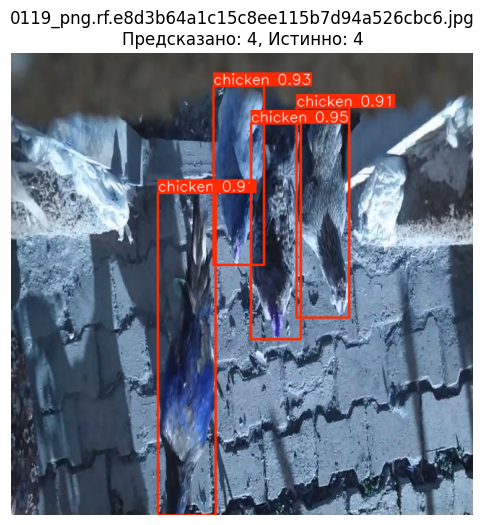

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


model = YOLO("runs/detect/chicken_yolo3/weights/best.pt")

abs_errors = []
squared_errors = []
adaptive_correct = 0
total = 0

#Прогон по всему тесту
for img_info in test_imgs:
    fname = img_info['file_name']
    img_path = base_dir / "images" / "test" / fname
    true_count = true_counts.get(fname, 0)

    result = model.predict(source=str(img_path), conf=0.25, verbose=False)
    pred_count = len(result[0].boxes)
    
    abs_errors.append(abs(pred_count - true_count))
    squared_errors.append((pred_count - true_count) ** 2)

    #Метрика увеличивает порог правильности в зависимости от реального количества куриц на фотографии
    tolerance = max(1, round(0.15 * true_count))
    if abs(pred_count - true_count) <= tolerance:
        adaptive_correct += 1
    total += 1

#Метрики
mae = np.mean(abs_errors)
rmse = np.sqrt(np.mean(squared_errors))
adaptive_accuracy = adaptive_correct / total * 100

print(f"MAE (средняя ошибка по количеству): {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Accuracy@adaptive_tolerance: {adaptive_accuracy:.2f}%")

#Вывод  случайных изображений для наглядности 
sample_imgs = random.sample(test_imgs, 3)
for img_info in sample_imgs:
    fname = img_info['file_name']
    img_path = base_dir / "images" / "test" / fname
    true_count = true_counts.get(fname, 0)
    result = model.predict(source=str(img_path), conf=0.25, verbose=False)
    pred_count = len(result[0].boxes)

    #Визуализация
    result[0].plot()
    img = Image.fromarray(result[0].plot())
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{fname}\nПредсказано: {pred_count}, Истинно: {true_count}")
    plt.show()


In [27]:
best_weights = Path("runs/detect/chicken_yolo3/weights/best.pt")
shutil.copy(best_weights, "/kaggle/working/yolov8_chicken_best.pt")
print("Веса сохранены:", "/kaggle/working/yolov8_chicken_best.pt")


Веса сохранены: /kaggle/working/yolov8_chicken_best.pt
